# Hierarchical Clustering

## Autoreload

Autoreload allows the notebook to dynamically load code: if we update some helper functions *outside* of the notebook, we do not need to reload the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import procyclingstats as pcs
import umap

from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

# Otherwise nothing will be found
sys.path.append(os.path.abspath(os.path.join('..')))

from utility.cluster_utility import scale_data, hier_search, get_average_cyclist_per_cluster

c:\Users\Yuri\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Global variables, constants, etc.

In [3]:
sys.path.append('../dataset/')
sys.path.append('../utility/')

# Global variables, constants
IMAGE_DIR = '../images/'
RANDOM_STATE = 42
hyperparametrs = {
    'n_clusters': np.arange(3, 21), # starting from 3 because with 2 clusters we just get outlier detection
    'linkage': ['single', 'complete', 'average', 'ward']
}

We've spent a lot of effort into engineering new features, understanding them, etc. Whether we've done this well and whether is enough it's a different story.

The point here is that - after the understanding, engineering and transformation - we have some cleaned-up versions of the datasets.

In [4]:
cyclists_df = pd.read_csv('../dataset/cyclists_cleaned.csv')
races_df = pd.read_csv('../dataset/races_cleaned.csv')

Let's reduce the dimensionality of the dataset by dropping useless or non-descriptive columns.

In [5]:
cyclists_df = cyclists_df.select_dtypes(include=[np.number])
cyclists_df = cyclists_df.drop(columns=['birth_year', 'weight', 'height', 'victories_by_points', 'avg_points_per_race', 'stamina_index'])
cyclists_df = cyclists_df.dropna()

Let's scale the data

In [6]:
cyc_normalizer, cyc_normalized = scale_data(cyclists_df)

Let's check how the silhouette scores for the selected linkage types and maximum clusters compare

In [7]:
silhouettes = hier_search(hyperparametrs, cyc_normalized)

c:\Users\Yuri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 72 is smaller than n_iter=80. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Let's plot them

In [8]:
silhouettes

n_clusters   linkage  random_state  silhouette
0            3    single            42    0.775448
1            4    single            42    0.729897
36           3   average            42    0.461991
2            5    single            42    0.449962
3            6    single            42    0.426110
..         ...       ...           ...         ...
27          12  complete            42    0.083841
35          20  complete            42    0.078172
32          17  complete            42    0.070723
33          18  complete            42    0.070003
34          19  complete            42    0.065641

[72 rows x 4 columns]

Looks like the best silhouette score is reached by single linkages with 3 clusters. Let's try to plot it

In [9]:
single_linkage = AgglomerativeClustering(n_clusters=3, linkage='single')
labels = single_linkage.fit_predict(cyc_normalized)

In [10]:
cyclists_df['cluster'] = labels

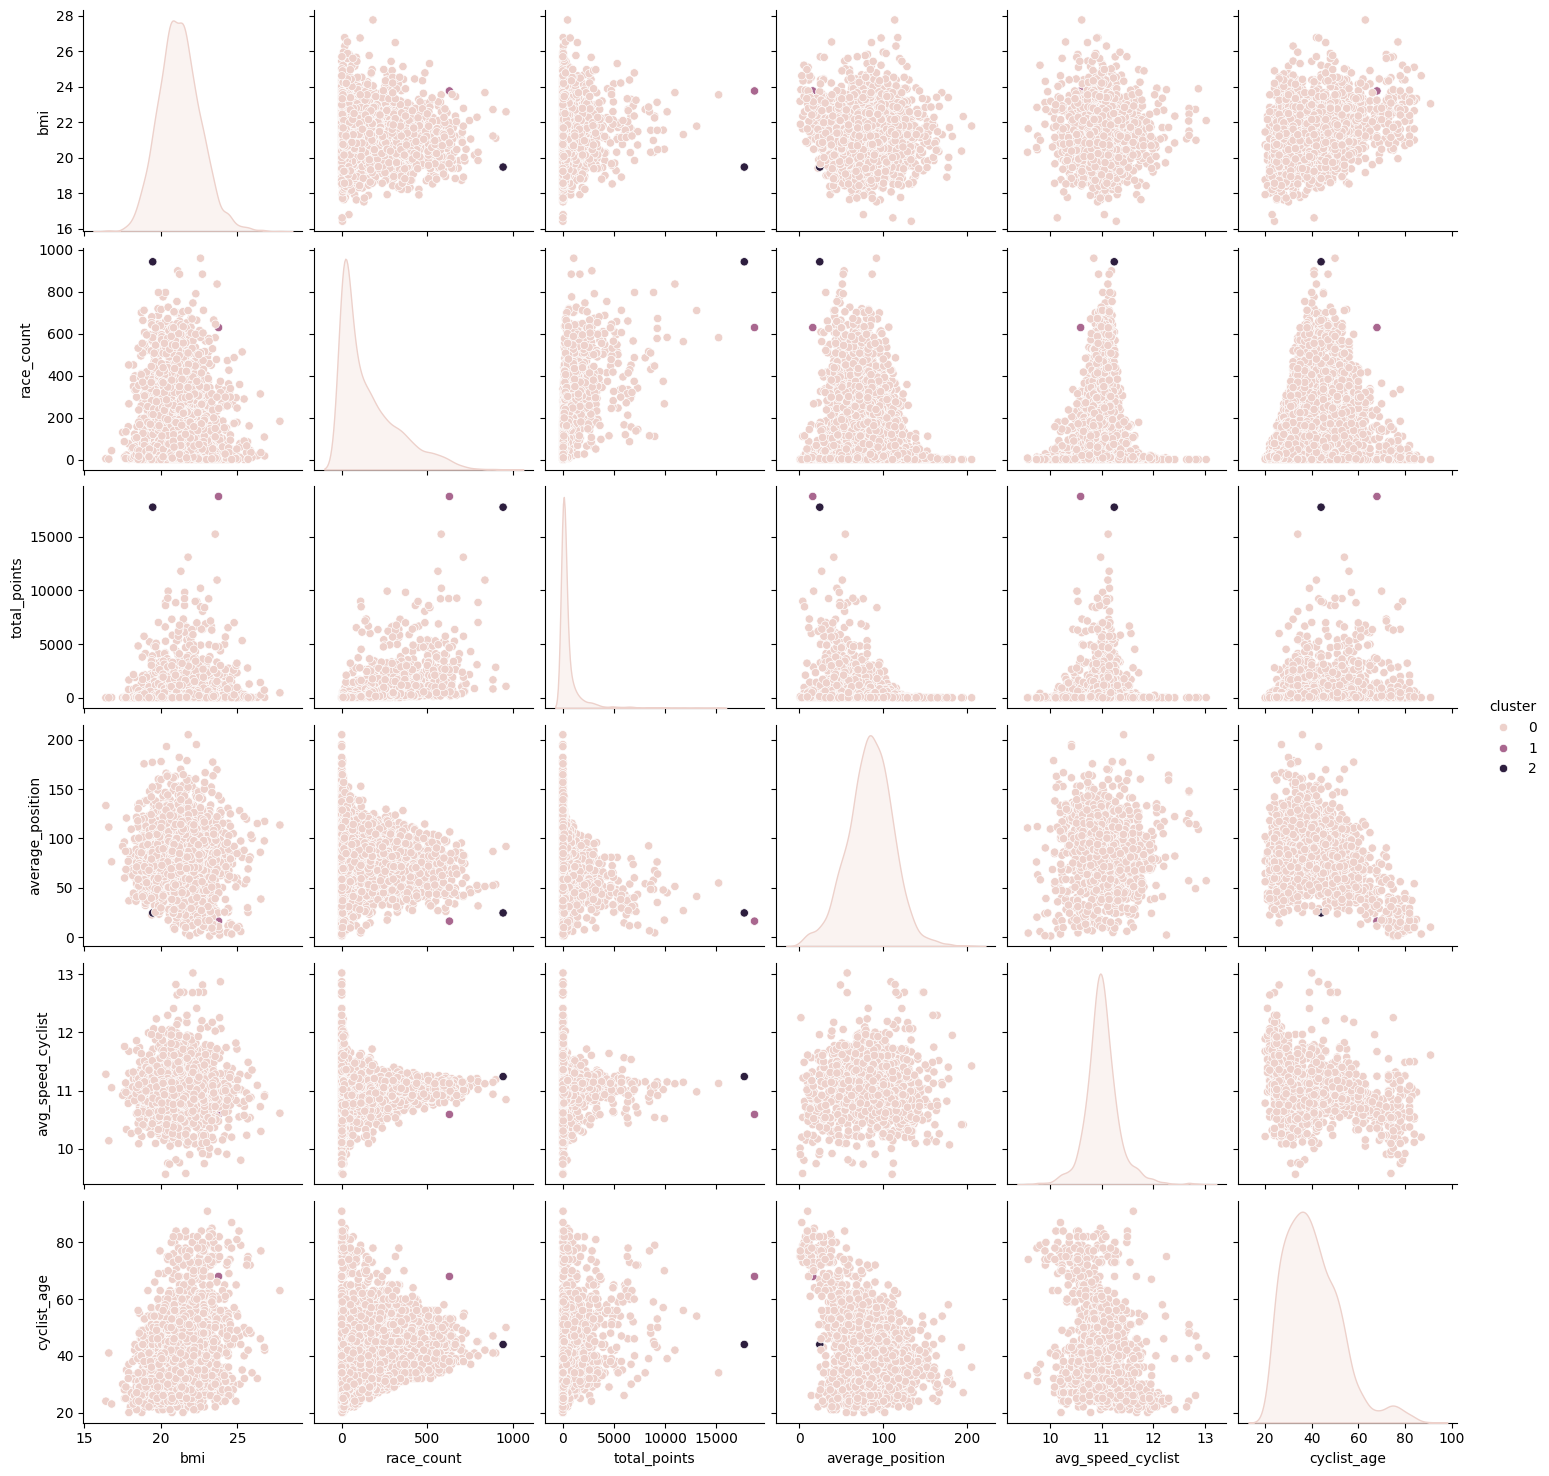

In [11]:
# plot all pairs of values and color by cluster
sns.pairplot(cyclists_df, hue='cluster')
plt.show()

And it just looks like a mediocre result for outlier detection! As expected, MIN suffers a lot from outliers and noise. Let's check how the best average works

In [12]:
single_linkage = AgglomerativeClustering(n_clusters=3, linkage='average')
labels = single_linkage.fit_predict(cyc_normalized)

In [13]:
cyclists_df['cluster'] = labels

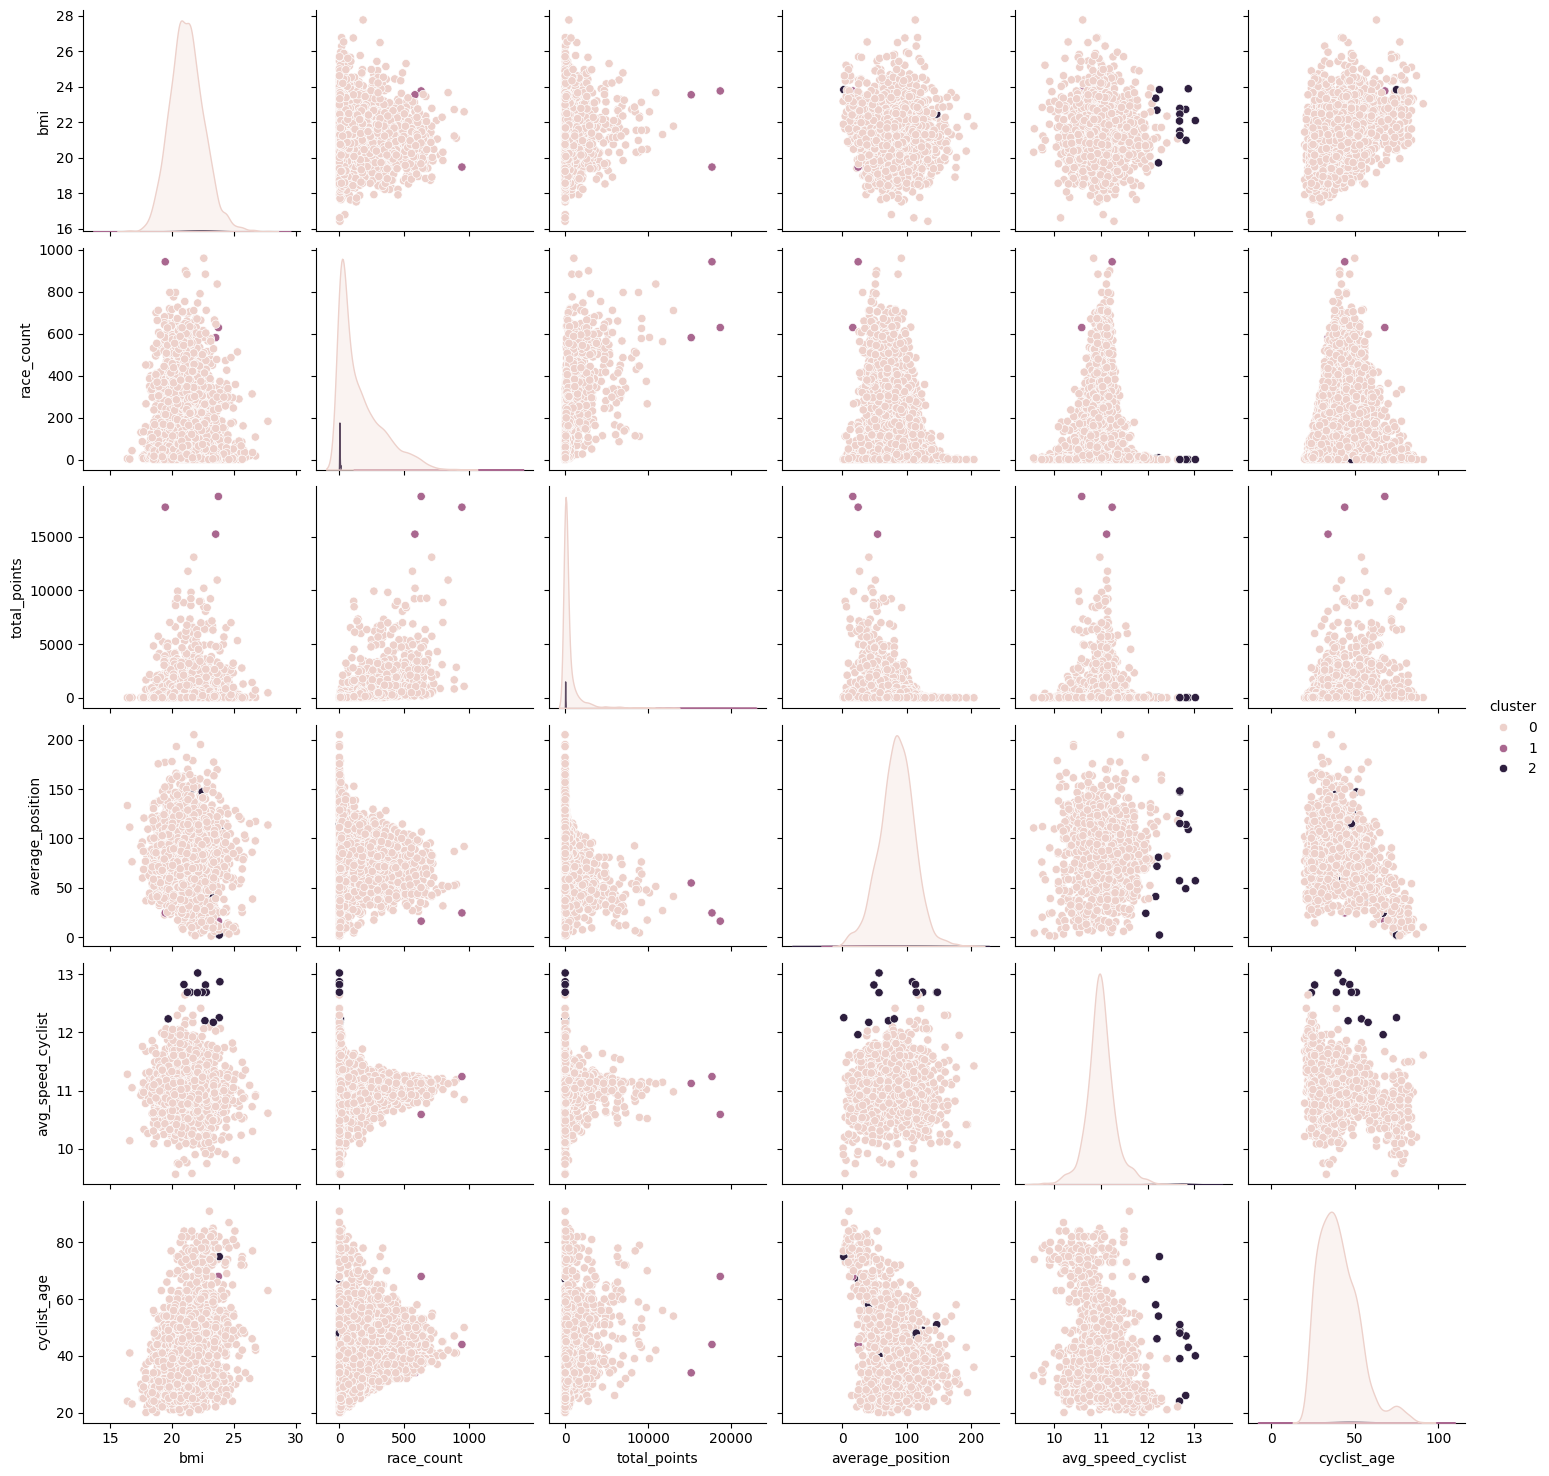

In [14]:
# plot all pairs of values and color by cluster
sns.pairplot(cyclists_df, hue='cluster')
plt.show()

It's still suffering, albeit doing a bit better. The main reason seems to be some cyclists having totalized a great deal of points. Let's check how MAX goes.

In [15]:
# show only the rows of silhouettes where linkage = 'complete'

silhouettes[silhouettes['linkage'] == 'complete']

n_clusters   linkage  random_state  silhouette
18           3  complete            42    0.267048
19           4  complete            42    0.240744
20           5  complete            42    0.221928
21           6  complete            42    0.201651
22           7  complete            42    0.184731
28          13  complete            42    0.097709
29          14  complete            42    0.096991
30          15  complete            42    0.094477
23           8  complete            42    0.094014
24           9  complete            42    0.093589
31          16  complete            42    0.093231
25          10  complete            42    0.092329
26          11  complete            42    0.084610
27          12  complete            42    0.083841
35          20  complete            42    0.078172
32          17  complete            42    0.070723
33          18  complete            42    0.070003
34          19  complete            42    0.065641

In [30]:
complete_linkage = AgglomerativeClustering(n_clusters=3, linkage='complete')
labels = complete_linkage.fit_predict(cyc_normalized)
cyclists_df['cluster'] = labels

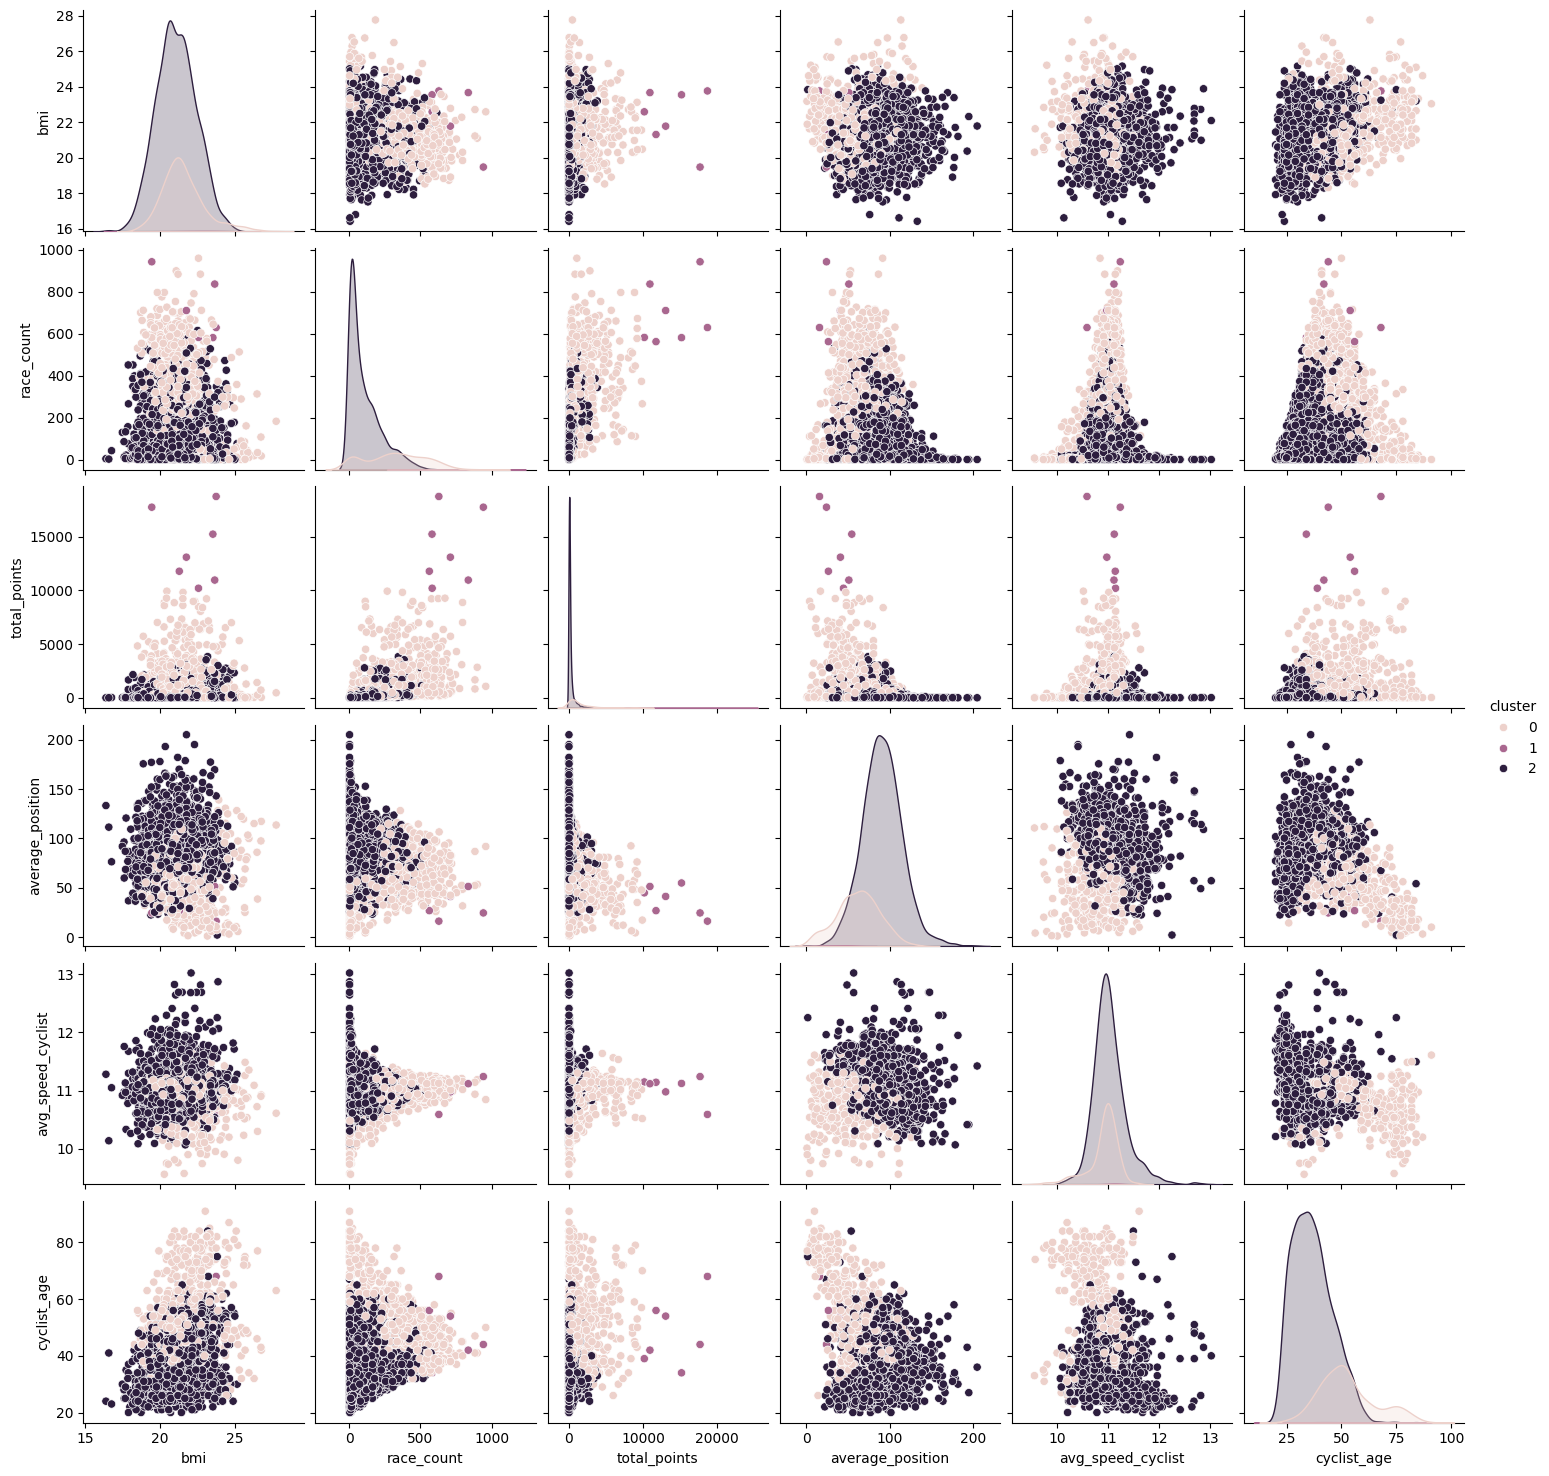

In [31]:
# plot all pairs of values and color by cluster
sns.pairplot(cyclists_df, hue='cluster')
plt.show()

Well, a bit of a more satisfying division.

In [32]:
get_average_cyclist_per_cluster(labels, cyclists_df)

bmi  race_count  total_points  average_position  \
cluster                                                          
0        21.560121  320.821277   1532.944681         62.046133   
1        22.303936  691.714286  13951.142857         37.000781   
2        21.101334  105.420648    207.380119         90.886232   

         avg_speed_cyclist  cyclist_age  cluster_size  
cluster                                                
0                10.904251    52.605674           705  
1                11.049186    48.142857             7  
2                11.031797    36.739761          2344

The first cluster represents experienced, older cyclists who participate in a good number of races and perform moderately well. 
The second cluster represents a small group of competitive cyclists that perform exceedingly well and have the highest experience. 
The third cluster consists of younger and less experienced cyclists that tend to end up in poorer positions.


Let's check how Ward's Method fared

In [19]:
# show only the rows of silhouettes where linkage = 'complete'

silhouettes[silhouettes['linkage'] == 'ward']

n_clusters linkage  random_state  silhouette
56           5    ward            42    0.177124
57           6    ward            42    0.157668
55           4    ward            42    0.156493
54           3    ward            42    0.142955
58           7    ward            42    0.141593
59           8    ward            42    0.127948
66          15    ward            42    0.103498
62          11    ward            42    0.103006
61          10    ward            42    0.102310
64          13    ward            42    0.101859
65          14    ward            42    0.101221
63          12    ward            42    0.098780
69          18    ward            42    0.097794
71          20    ward            42    0.096767
68          17    ward            42    0.096632
70          19    ward            42    0.096383
60           9    ward            42    0.095714
67          16    ward            42    0.094963

In [20]:
complete_linkage = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels = complete_linkage.fit_predict(cyc_normalized)
cyclists_df['cluster'] = labels

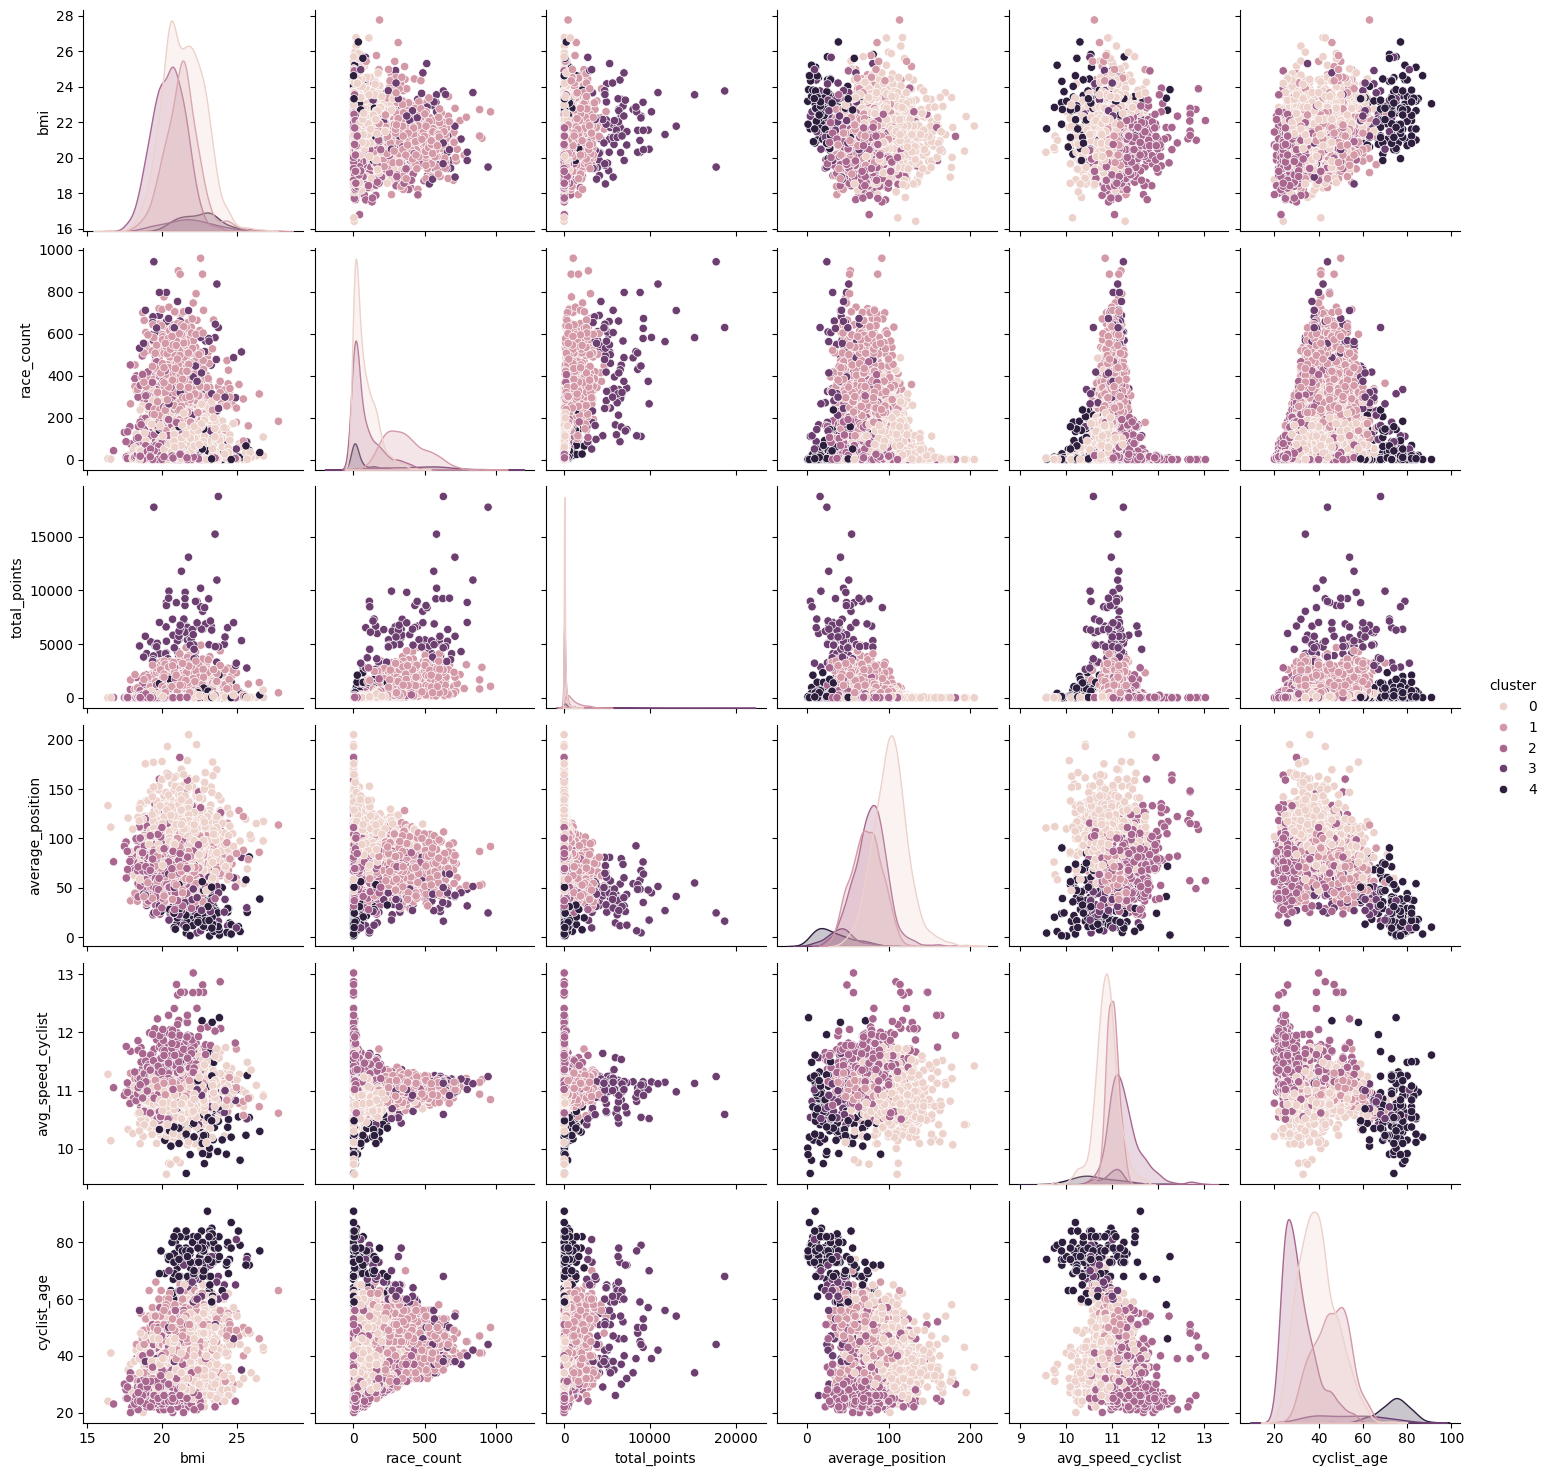

In [21]:
# plot all pairs of values and color by cluster
sns.pairplot(cyclists_df, hue='cluster')
plt.show()

In [ ]:
get_average_cyclist_per_cluster(labels, cyclists_df)

bmi  race_count  total_points  average_position  \
cluster                                                          
0        21.462963   78.314598     98.416862        102.379561   
1        21.339548  361.312757   1075.913580         72.931841   
2        20.467163   83.976190    154.450000         77.650370   
3        21.768423  433.611111   6448.277778         41.779786   
4        22.546369   41.758621    379.198276         32.214098   

         avg_speed_cyclist  cyclist_age  cluster_size  
cluster                                                
0                10.870260    39.484778          1281  
1                11.003226    45.727023           729  
2                11.251414    31.329762           840  
3                10.992790    52.655556            90  
4                10.661038    73.887931           116

Division seem to be mainly focused on the number of races and age. <br>
The first is the largest group of cyclists, on the young-middle age side, who partecipated in quite some races but tend to have mediocre performances. <br>
The second represents more experienced cyclists that accumulated a discrete number of points. Their performance is better, albeit still mediocre, and their average speed is slightly above other clusters 
The third consists of the youngest and most lightweight cyclists who perform almost as well as the previous cluster. Albeit inexperienced, they are the fastest cluster. <br>
The fourth seems to represent a group of the best, most experienced cyclists with great performance metrics. <br>
The last cluster represents, probably, historical cyclists that performed exceptionally well. It is interesting to note that their BMI is higher, compared to other groups, and that their race count isn't that high, probably due to not much data being cleanly collected on them


In [22]:
reducer = umap.UMAP(n_neighbors=15, learning_rate=0.1, n_components=3, random_state=RANDOM_STATE)

In [23]:
reduced_data = reducer.fit_transform(cyc_normalized)

c:\Users\Yuri\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [24]:
single_linkage.fit_predict(reduced_data)

array([2, 0, 0, ..., 0, 2, 0], dtype=int64)

In [25]:
import plotly.express as px
import pandas as pd

# Prepare data for Plotly
df = pd.DataFrame({
    'UMAP 1': reduced_data[:, 0],
    'UMAP 2': reduced_data[:, 1],
    'UMAP 3': reduced_data[:, 2],
    'Cluster': single_linkage.labels_
})

# Create interactive 3D scatter plot
fig = px.scatter_3d(
    df,
    x='UMAP 1',
    y='UMAP 2',
    z='UMAP 3',
    color='Cluster',
    title='UMAP 3D',
    color_continuous_scale='Viridis'
)

# Show the interactive plot
fig.show()
